In [1]:
!pip install gdown
!nvidia-smi

Mon May 29 18:34:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 26%   25C    P8     6W / 180W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [190]:
!gdown --id "1ohWrj07z1iN9Rum_OZWIbTVhNUn4r5Bg&confirm=t"

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ohWrj07z1iN9Rum_OZWIbTVhNUn4r5Bg&confirm=t
To: /notebooks/175467_data_norm.pt
100%|████████████████████████████████████████| 102k/102k [00:00<00:00, 26.8MB/s]


#### Utils

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import List, Tuple


class Eops():
  # Following https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b
  def zero_grad(self):
    for parameter in self.parameters():
      parameter.grad = None

  def _init_weights(self, module: nn.Module):
    classname = module.__class__.__name__
    if classname.find("Linear") != -1:
      nn.init.xavier_uniform_(module.weight)
      if module.bias is not None:
        nn.init.zeros_(module.bias)
    elif classname.find("Conv") != -1:
      nn.init.xavier_uniform_(module.weight)

  def spectral_norm(self, module: nn.Module):
    classname = module.__class__.__name__
    if classname.find("Linear") != -1 or classname.find("Conv") != -1:
      module = torch.nn.utils.parametrizations.spectral_norm(module=module)

  def num_params(self):
    return f"{self.__class__.__name__}: {sum(p.numel() for p in self.parameters())/1e6} M parameters"
  
  def load_pretrained(self, filepath, device="cpu"):
    print(f"Loading weights for {self.__class__.__name__} from {filepath}")
    print(self.load_state_dict(torch.load(filepath, map_location=torch.device(device))))


class TripletLoss(nn.Module):
  def __init__(self, margin: float = 1.5):
    super(TripletLoss, self).__init__()
    self.register_buffer("margin", torch.tensor(margin))

  def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor = None) -> Tuple[torch.Tensor]:
    """
    Goal: Anchor / Positive -> minimize distance, Anchor / Negative -> maximize distance 
    Implementation available in PyTorch (does not include squaring the distances): nn.TripletMarginLoss(1.5)(anchor, positive, negative).
    """
    loss_dict = { "loss": None }
    euclidean_distance_positive = torch.mean(F.pairwise_distance(anchor, positive, keepdim=True), dim=1)
    loss_dict["ap_distance"] = euclidean_distance_positive
    if negative is not None:
      euclidean_distance_negative = torch.mean(F.pairwise_distance(anchor, negative, keepdim=True), dim=1)
      loss = torch.mean(torch.relu(torch.pow(euclidean_distance_positive, 2) - torch.pow(euclidean_distance_negative, 2) + self.margin))
      loss_dict["loss"] = loss
      loss_dict["an_distance"] = euclidean_distance_negative
      # difference should be > 0 (Anchor-Negative distance should be greater than Anchor-Positive distance)
      loss_dict["an_ap_diff"] = loss_dict["an_distance"] - loss_dict["ap_distance"]

    return loss_dict

#### Models

In [191]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from time import time 
from tqdm import tqdm

#================ Variables ================#

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128 
leaky_relu_slope = 0.05

block_size = 16  # -> window size for the dataset (length of the context)
latent_dim = 500 # -> size of the latent space
embedding_dim = 144 # -> embedding dimension for the condition 
ffn_dropout = 0.2 # -> dropout for feed-forward networks
vocab_size = 101 # -> to be used in ks_embedding_table, equals to 100
generator_output_dim = 2 # -> generate 4 values for each symbol (64 in total)

#================ Variables ================#

class Generator(nn.Module, Eops):
  def __init__(self):
    super(Generator, self).__init__()
    self.label_conditioned_generator = nn.Sequential(
      nn.Embedding(vocab_size, embedding_dim),
      nn.Linear(embedding_dim, 512, bias=False)
    )

    self.latent = nn.Sequential(
      nn.Linear(latent_dim, 8 * 16 * 64, bias=False),
      nn.LeakyReLU(leaky_relu_slope, inplace=True)
    )

    self.lstm1 = nn.LSTM(input_size=1024, hidden_size=128, num_layers=2, bias=False, batch_first=True, dropout=0.2)
    self.fc = nn.Linear(in_features=128, out_features=512, bias=False)

    self.model = nn.Sequential(
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(in_features=512, out_features=1024, bias=False),
      nn.LayerNorm(1024),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(in_features=1024, out_features=256, bias=False),
      nn.LayerNorm(256),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Dropout(ffn_dropout),
      nn.Linear(in_features=256, out_features=128, bias=False),
      nn.LayerNorm(128),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(in_features=128, out_features=generator_output_dim, bias=False),
      nn.Sigmoid()
    )

    self.apply(self._init_weights)

  def forward(self, latent_space, condition):
    condition_out = self.label_conditioned_generator(condition)
    latent_out = self.latent(latent_space)
    condition_out = condition_out.view(-1, 16, 4 * 128)
    latent_out = latent_out.view(-1, 16, 4 * 128)
    concat = torch.cat((latent_out, condition_out), dim=2)

    x, _ = self.lstm1(concat)
    x = self.fc(x)
    x = F.dropout(x, 0.5)
    x = self.model(x)


    return x


class Discriminator(nn.Module, Eops):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.label_conditioned_discriminator = nn.Sequential(
      nn.Embedding(vocab_size, embedding_dim),
      nn.Linear(embedding_dim, 32, bias=False)
    )

    self.embed_keystroke = nn.Sequential(
      nn.Linear(in_features=generator_output_dim, out_features=512),
      nn.LeakyReLU(leaky_relu_slope, inplace=True)
    )

    self.lstm1 = nn.LSTM(input_size=544, hidden_size=128, num_layers=2, bias=False, batch_first=True, dropout=0.2)
    self.fc = nn.Linear(in_features=128, out_features=1024, bias=False)

    self.model = nn.Sequential(
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(1024, 512),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Dropout(ffn_dropout * 2),
      nn.Linear(512, 256),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(256, 1),
    )

    self.head = nn.Linear(16, 1)
    self.sigmoid = nn.Sigmoid()
    self.apply(self._init_weights)

  def forward(self, keystroke_times, condition_symbols):
    condition_out = self.label_conditioned_discriminator(condition_symbols)
    keystroke_times = self.embed_keystroke(keystroke_times)
    x = torch.cat((keystroke_times, condition_out), dim=2)
    x, _ = self.lstm1(x)
    x = self.fc(x)
    x = F.dropout(x, 0.5)
    x = self.model(x)
    x = x.view(batch_size, -1)
    x = self.head(x)

    return self.sigmoid(x)

#### Train Loop

In [594]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm


#================ Variables ================#
num_epochs = 300    # -> number of time the model will see whole dataset
epoch_log = 1 # -> prints per epoch 
evaluation_interval = 20 # -> evaluate model every 'revaluation_interval' epoch

generator_lr = 1e-4 # -> generator learning rate
discriminator_lr = 2e-4 # -> discriminator learning rate
adam_beta1 = 0.5 # -> beta1 for AdamW optimizer
adam_beta2 = 0.999 # -> beta2 (momentum) value for AdamW optimizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


@torch.no_grad()
def evaluate_model(generator, discriminator, dataloader):
  generator.eval()
  discriminator.eval()
  real_accuracy, fake_accuracy = 0, 0
  reconstruction_loss = 0
  kl_div = 0

  actuals = torch.tensor([], dtype=torch.float32, device=device)
  outs = torch.tensor([], dtype=torch.float32, device=device)

  for i, (ks_symbols, ks_times) in enumerate(dataloader):
    # if ks_symbols.shape[0] < batch_size:
    #   continue
    ks_times, ks_symbols = ks_times.to(device), ks_symbols.to(device)
    latent_space = torch.randn(ks_symbols.shape[0], latent_dim, device=device)
    generated_out = generator(latent_space, ks_symbols)
    reconstruction_loss += F.mse_loss(input=generated_out, target=ks_times).item()
    kl_div += distribution_similarity(generated_out, ks_times)

    labels = torch.ones(ks_symbols.shape[0], 1, device=device)
    disc_real_output = discriminator(ks_times, ks_symbols)
    real_accuracy += (torch.round(disc_real_output) == labels).float().mean().item()
    
    labels.fill_(0.)

    disc_fake_output = discriminator(generated_out, ks_symbols)
    fake_accuracy += (torch.round(disc_fake_output) == labels).float().mean().item()

    actuals = torch.cat((actuals, ks_times))
    outs = torch.cat((outs, generated_out))


  reconstruction_loss /= len(dataloader)
  kl_div /= len(dataloader)
  real_accuracy /= len(dataloader)
  fake_accuracy /= len(dataloader)

  discriminator.train()
  generator.train()

  return actuals, outs, reconstruction_loss, kl_div, real_accuracy, fake_accuracy


def distribution_similarity(generated_dist, actual_dist):
  generated_scaled = (generated_dist - actual_dist.mean()) / actual_dist.std()  # if similar to actual -> result should be close to the normal one 
  kl_loss = torch.log(generated_scaled.std()) + (1 + torch.square(generated_scaled.mean())) / (2 * torch.square(generated_scaled.std())) - 0.5 # compare with the normal one 
  return kl_loss


def calculate_loss(input, target):
  return F.binary_cross_entropy(input, target)


def reconstruction_loss(input, target):
  return F.mse_loss(input=input, target=target).item()


def train_step(models, optims, keystrokes, keystroke_times, rl_loss_lambda):
  generator, discriminator = models
  optim_G, optim_D = optims

  # 1. Prepare data (set real / fake labels)
  keystrokes, real_keystroke_times = keystrokes.to(device), keystroke_times.to(device)
  real_label = torch.ones(keystrokes.shape[0], 1, device=device)
  fake_label = torch.zeros(keystrokes.shape[0], 1, device=device)

  # 2. Train the discriminator
  discriminator.zero_grad()
  real_loss_D = calculate_loss(discriminator(real_keystroke_times, keystrokes), real_label)
  latent_space = torch.randn(keystrokes.shape[0], latent_dim, device=device)
  generated_keystroke_times = generator(latent_space, keystrokes)
  fake_loss_D = calculate_loss(discriminator(generated_keystroke_times.detach(), keystrokes), fake_label)
  total_loss_D = (real_loss_D + fake_loss_D) / 2
  mse_loss = reconstruction_loss(generated_keystroke_times, real_keystroke_times)
  total_loss_D = total_loss_D + rl_loss_lambda * mse_loss
  total_loss_D.backward()
  optim_D.step()

  # 3. Train the generator
  generator.zero_grad()
  loss_G = calculate_loss(discriminator(generated_keystroke_times, keystrokes), real_label)
  loss_G = loss_G + rl_loss_lambda * mse_loss
  loss_G.backward()
  optim_G.step()

  return loss_G, total_loss_D, mse_loss


def train_loop(generator, discriminator, train_dataloader, validation_dataloader, device=device, rl_loss_lambda=5, verbose=10):
  actuals, outputs = [], []
  loss_list_D, loss_list_G, mse_losses = [], [], []
  real_accuracies, fake_accuracies, eval_reconstruction_losses, kl_divergences = [], [], [], [] 
  generator, discriminator = generator.to(device), discriminator.to(device)
  optim_G = torch.optim.AdamW(generator.parameters(), lr=generator_lr, betas=(adam_beta1, adam_beta2))
  optim_D = torch.optim.AdamW(discriminator.parameters(), lr=discriminator_lr, betas=(adam_beta1, adam_beta2))

  for epoch in tqdm(range(1, num_epochs + 1)):
    curr_loss_G, curr_loss_D, curr_mse = 0, 0, 0
    for index, (keystroke_symbols, keystroke_times) in enumerate(train_dataloader):
      loss_G, loss_D, mse_loss = train_step(models=(generator, discriminator), optims=(optim_G, optim_D), 
                                  keystrokes=keystroke_symbols, keystroke_times=keystroke_times, rl_loss_lambda=rl_loss_lambda)
      curr_loss_G += loss_G.item()
      curr_loss_D += loss_D.item()
      curr_mse += mse_loss

      # if index % (len(train_dataloader) // epoch_log) == 0:
      #   print(f"[Epoch: {epoch} / {num_epochs}][{index:4d}/{len(train_dataloader):4d}] Generator loss: {loss_G:2.5f}, discriminator loss: {loss_D:2.5f}")
    
    if epoch % evaluation_interval == 0:
      acts, outs, loss, kl_div, real_accuracy, fake_accuracy = evaluate_model(generator, discriminator, validation_dataloader)
      actuals.append(acts)
      outputs.append(outs)
      real_accuracies.append(real_accuracy)
      fake_accuracies.append(fake_accuracy)
      eval_reconstruction_losses.append(loss)
      kl_divergences.append(kl_div)
      print(f"MSE loss: {loss:2.5f}, KL div: {kl_div:2.5f}, Real accuracy: {real_accuracy:2.5f}, Fake accuracy: {fake_accuracy:2.5f}")

    curr_loss_G /= len(train_dataloader)
    curr_loss_D /= len(train_dataloader)
    curr_mse /= len(train_dataloader)
    loss_list_D.append(curr_loss_D)
    loss_list_G.append(curr_loss_G)
    mse_losses.append(curr_mse)

    if epoch % verbose == 0:
      print(f"###### [Epoch: {epoch} / {num_epochs}] Epoch MSE loss: {curr_mse:2.10f} Epoch generator loss: {curr_loss_G:2.5f}, Epoch discriminator loss: {curr_loss_D:2.5f}")

  return actuals, outputs, loss_list_G, loss_list_D, mse_losses, eval_reconstruction_losses, kl_divergences, real_accuracies, fake_accuracies


#### Process

In [595]:
!ls

 175467_data_norm.pt   models			    tn_test_500.pt
 233209_data_norm.pt   msc			    tn_train_100.pt
 416085_data_norm.pt   norm_data_10000_128.pt	    tn_train_500.pt
 MNIST		       norm_data_1000_128.pt	    tn_valid_100.pt
 README.md	       norm_data_100_128.pt	    tn_valid_500.pt
'UCI HAR Dataset'      norm_data_5000_128.pt	    tsa_project.ipynb
 __MACOSX	       norm_data_50_128.pt	   'view?usp=sharing'
 data		       one-user-norm-32.pt	   'view?usp=sharing.1'
 dataset.zip	       quick_start_pytorch_images
 dcgan.ipynb	       tn_test_100.pt


In [603]:
dataloader = torch.load("416085_data_norm.pt")
len(dataloader), len(dataloader.dataset)

(3, 463)

In [604]:
generator_pt = Generator().to(device)
discriminator_pt = Discriminator().to(device)

generator_pt.load_pretrained("models/generator_big.pt")
discriminator_pt.load_pretrained("models/discriminator_big.pt")

Loading weights for Generator from models/generator_big.pt
<All keys matched successfully>
Loading weights for Discriminator from models/discriminator_big.pt
<All keys matched successfully>


In [605]:
actuals, outputs, loss_list_G, loss_list_D, mse_losses, eval_reconstruction_losses, kl_divergences, real_accuracies, fake_accuracies = train_loop(generator_pt, 
                                                                                                                                                  discriminator_pt, 
                                                                                                                                                  dataloader,
                                                                                                                                                  dataloader,
                                                                                                                                                  verbose=25)

  7%|▋         | 21/300 [00:02<00:32,  8.54it/s]

MSE loss: 0.00077, KL div: 0.00306, Real accuracy: 0.99479, Fake accuracy: 0.86719


  9%|▊         | 26/300 [00:02<00:30,  9.11it/s]

###### [Epoch: 25 / 300] Epoch MSE loss: 0.0007831656 Epoch generator loss: 6.04260, Epoch discriminator loss: 0.16585


 14%|█▎        | 41/300 [00:04<00:29,  8.69it/s]

MSE loss: 0.00081, KL div: 0.00191, Real accuracy: 1.00000, Fake accuracy: 0.96094


 17%|█▋        | 51/300 [00:05<00:26,  9.24it/s]

###### [Epoch: 50 / 300] Epoch MSE loss: 0.0008441498 Epoch generator loss: 7.16476, Epoch discriminator loss: 0.09676


 20%|██        | 61/300 [00:06<00:27,  8.69it/s]

MSE loss: 0.00088, KL div: 0.01020, Real accuracy: 1.00000, Fake accuracy: 0.96875


 25%|██▌       | 76/300 [00:08<00:23,  9.43it/s]

###### [Epoch: 75 / 300] Epoch MSE loss: 0.0007414012 Epoch generator loss: 7.93342, Epoch discriminator loss: 0.04799


 27%|██▋       | 81/300 [00:08<00:24,  8.88it/s]

MSE loss: 0.00073, KL div: 0.00147, Real accuracy: 1.00000, Fake accuracy: 0.98177


 34%|███▎      | 101/300 [00:11<00:23,  8.63it/s]

MSE loss: 0.00072, KL div: 0.00140, Real accuracy: 1.00000, Fake accuracy: 0.96875
###### [Epoch: 100 / 300] Epoch MSE loss: 0.0007394344 Epoch generator loss: 8.69175, Epoch discriminator loss: 0.05256


 40%|████      | 121/300 [00:13<00:20,  8.87it/s]

MSE loss: 0.00067, KL div: 0.00102, Real accuracy: 1.00000, Fake accuracy: 0.97396


 42%|████▏     | 126/300 [00:13<00:18,  9.36it/s]

###### [Epoch: 125 / 300] Epoch MSE loss: 0.0006696874 Epoch generator loss: 9.26785, Epoch discriminator loss: 0.04697


 47%|████▋     | 141/300 [00:15<00:18,  8.68it/s]

MSE loss: 0.00061, KL div: 0.00495, Real accuracy: 1.00000, Fake accuracy: 0.96875


 50%|█████     | 151/300 [00:16<00:15,  9.38it/s]

###### [Epoch: 150 / 300] Epoch MSE loss: 0.0006024531 Epoch generator loss: 9.52732, Epoch discriminator loss: 0.04914


 54%|█████▎    | 161/300 [00:17<00:15,  8.95it/s]

MSE loss: 0.00053, KL div: 0.01034, Real accuracy: 1.00000, Fake accuracy: 0.94531


 59%|█████▊    | 176/300 [00:19<00:12,  9.55it/s]

###### [Epoch: 175 / 300] Epoch MSE loss: 0.0005388353 Epoch generator loss: 9.61982, Epoch discriminator loss: 0.05994


 60%|██████    | 181/300 [00:19<00:13,  8.98it/s]

MSE loss: 0.00055, KL div: 0.00382, Real accuracy: 1.00000, Fake accuracy: 0.94010


 67%|██████▋   | 201/300 [00:21<00:11,  8.99it/s]

MSE loss: 0.00053, KL div: 0.00033, Real accuracy: 1.00000, Fake accuracy: 0.91667
###### [Epoch: 200 / 300] Epoch MSE loss: 0.0005836757 Epoch generator loss: 10.14240, Epoch discriminator loss: 0.05068


 74%|███████▎  | 221/300 [00:24<00:09,  8.76it/s]

MSE loss: 0.00053, KL div: 0.00217, Real accuracy: 1.00000, Fake accuracy: 0.91406


 75%|███████▌  | 226/300 [00:24<00:08,  9.14it/s]

###### [Epoch: 225 / 300] Epoch MSE loss: 0.0005620279 Epoch generator loss: 9.47066, Epoch discriminator loss: 0.06560


 80%|████████  | 241/300 [00:26<00:06,  8.89it/s]

MSE loss: 0.00047, KL div: 0.00218, Real accuracy: 1.00000, Fake accuracy: 0.88021


 84%|████████▎ | 251/300 [00:27<00:05,  9.51it/s]

###### [Epoch: 250 / 300] Epoch MSE loss: 0.0004680846 Epoch generator loss: 9.73249, Epoch discriminator loss: 0.08679


 87%|████████▋ | 261/300 [00:28<00:04,  8.91it/s]

MSE loss: 0.00047, KL div: 0.00632, Real accuracy: 1.00000, Fake accuracy: 0.86979


 92%|█████████▏| 276/300 [00:29<00:02,  9.29it/s]

###### [Epoch: 275 / 300] Epoch MSE loss: 0.0004372079 Epoch generator loss: 9.07967, Epoch discriminator loss: 0.09315


 94%|█████████▎| 281/300 [00:30<00:02,  8.71it/s]

MSE loss: 0.00047, KL div: 0.01078, Real accuracy: 1.00000, Fake accuracy: 0.84896


100%|██████████| 300/300 [00:32<00:00,  9.21it/s]

MSE loss: 0.00041, KL div: 0.00753, Real accuracy: 1.00000, Fake accuracy: 0.84115
###### [Epoch: 300 / 300] Epoch MSE loss: 0.0004383115 Epoch generator loss: 8.82892, Epoch discriminator loss: 0.09329


In [606]:
import matplotlib.pyplot as plt 

for i in range(len(actuals)):
    actuals[i] = actuals[i].detach().cpu().numpy()
    outputs[i] = outputs[i].detach().cpu().numpy()

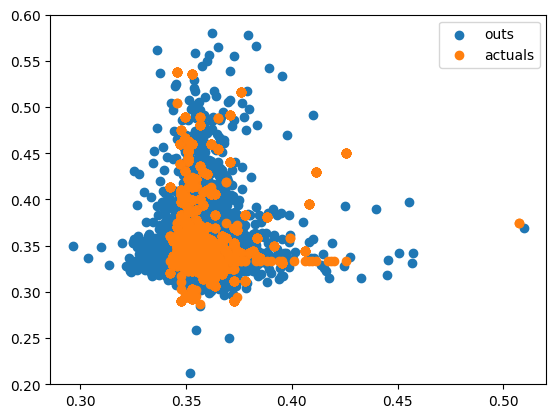

In [607]:
plt.scatter(outputs[0][:, :, 0], outputs[0][:, :, 1], label="outs")

plt.scatter(actuals[0][:, :, 0], actuals[0][:, :, 1], label="actuals")

plt.ylim([0.2, 0.6])

plt.legend()

In [608]:
len(outputs)

15

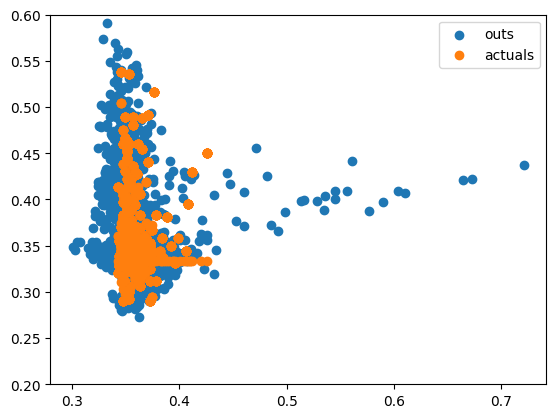

In [609]:
plt.scatter(outputs[14][:, :, 0], outputs[14][:, :, 1], label="outs")

plt.scatter(actuals[11][:, :, 0], actuals[11][:, :, 1], label="actuals")

plt.ylim([0.2, 0.6])

plt.legend()

In [100]:
actuals[0][:, :, 1]

tensor([[0.3333, 0.3547, 0.3458,  ..., 0.3422, 0.3547, 0.3191],
        [0.3333, 0.3336, 0.3349,  ..., 0.3422, 0.3582, 0.3422],
        [0.3333, 0.3422, 0.3351,  ..., 0.3387, 0.3387, 0.3689],
        ...,
        [0.3333, 0.3280, 0.3244,  ..., 0.3387, 0.3316, 0.3491],
        [0.3333, 0.3298, 0.3564,  ..., 0.3440, 0.3529, 0.4187],
        [0.3333, 0.3262, 0.4027,  ..., 0.3580, 0.3478, 0.3511]],
       device='cuda:0')

In [36]:
for X, y in dataloader:
    X, y = X.to(device), y.to(device)
    latent = torch.randn(X.shape[0], latent_dim, device=device)
    out = generator_pt(latent, X)
    d = discriminator_pt(out, X)
    break
    # print(X.shape, y.shape)

tensor([[1.8106e-05],
        [5.7807e-03],
        [5.5830e-04],
        [1.4300e-02],
        [3.4276e-05],
        [4.8122e-06],
        [1.0828e-05],
        [8.6842e-03],
        [3.8517e-02],
        [1.2136e-04],
        [4.1856e-04],
        [1.1718e-03],
        [2.1104e-01],
        [2.9925e-04],
        [6.8162e-04],
        [6.6865e-07],
        [8.9728e-01],
        [2.1916e-03],
        [3.0863e-01],
        [2.4080e-04],
        [4.6292e-02],
        [2.1122e-04],
        [4.7191e-01],
        [6.2244e-02],
        [8.6204e-04],
        [8.5841e-01],
        [6.9811e-01],
        [9.8566e-02],
        [3.6369e-04],
        [1.4272e-04],
        [4.2472e-01],
        [4.7321e-01],
        [4.5458e-03],
        [1.7120e-02],
        [2.3341e-01],
        [5.0702e-07],
        [3.0012e-02],
        [3.5008e-01],
        [2.6785e-04],
        [7.9623e-03],
        [7.7482e-03],
        [3.1965e-02],
        [1.5722e-03],
        [8.0281e-02],
        [1.1344e-04],
        [1